# 웹 검색 모듈 추가

**절차**

1. Naive RAG 수행
2. 검색된 문서에 대한 관련성 체크(Groundedness Check)
3. (이번 튜토리얼) Web Search 추가

**참고**

- 이전 튜토리얼에서 확장된 내용이므로, 겹치는 부분이 있을 수 있습니다. 부족한 설명은 이전 튜토리얼을 참고해주세요.

![langgraph-web-search](assets/langgraph-web-search.png)

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-RAG


## 기본 PDF 기반 Retrieval Chain 생성

여기서는 PDF 문서를 기반으로 Retrieval Chain 을 생성합니다. 가장 단순한 구조의 Retrieval Chain 입니다.

단, LangGraph 에서는 Retirever 와 Chain 을 따로 생성합니다. 그래야 각 노드별로 세부 처리를 할 수 있습니다.

**참고**

- 이전 튜토리얼에서 다룬 내용이므로, 자세한 설명은 생략합니다.

In [3]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

Cache configured for multi-PDF processing
Loading PDF: data/SPRI_AI_Brief_2023년12월호_F.pdf
Successfully loaded 23 pages from: data/SPRI_AI_Brief_2023년12월호_F.pdf

Loading Summary:
- Successfully loaded: 1 files
- Failed to load: 0 files
- Total documents loaded: 23
FAISS index saved to cache


## State 정의

`State`: Graph 의 노드와 노드 간 공유하는 상태를 정의합니다.

일반적으로 `TypedDict` 형식을 사용합니다.

이번에는 상태(State)에 관련성(relevance) 체크 결과를 추가합니다.

In [4]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)
    relevance: Annotated[str, "Relevance"]  # 관련성

## 노드(Node) 정의

- `Nodes`: 각 단계를 처리하는 노드입니다. 보통은 Python 함수로 구현합니다. 입력과 출력이 상태(State) 값입니다.
  
**참고**  

- `State`를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 `State`를 반환합니다.

In [5]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관련성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    # 관련성 평가기를 생성합니다.
    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4.1-nano", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_answer_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!
    return GraphState(relevance=response.score)


# 관련성 체크하는 함수(router)
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

## 검색 노드 추가

이번에는 `TavilySearch` 도구를 사용하여 Web Search 를 수행합니다.

아래는 `TavilySearch` 도구를 사용한 예제입니다.

In [6]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tavily_tool = TavilySearch()

search_query = "2024년 노벨 문학상 수상자는?"

# 다양한 파라미터를 사용한 검색 예제
search_result = tavily_tool.search(
    query=search_query,  # 검색 쿼리
    max_results=3,  # 최대 검색 결과
    format_output=True,  # 결과 포맷팅
)

# 검색 결과 출력
print(search_result)

['<document><title>[속보] 소설가 한강 노벨 문학상 수상..한국 작가 최초 수상 쾌거</title><url>https://www.youtube.com/watch?v=FsMuWl5LYNA</url><content>[속보] 소설가 한강 노벨 문학상 수상..한국 작가 최초 수상 쾌거 - [MBC 뉴스속보] 2024년 10월 10일\\nMBCNEWS\\n6010000 subscribers\\n18503 likes\\n827476 views\\n11 Oct 2024\\n올해 노벨 문학상 수상자가 우리나라 소설가, 한강 씨로 결정됐습니다.\\n\\n한국 첫 노벨 문학상의 쾌거입니다.\\n\\n한국인이 노벨상을 수상한 것은 지난 2000년 노벨평화상을 탄 고 김대중 전 대통령에 이어 두 번째로 24년 만입니다.\\n\\n노벨 위원회는 \\"역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문\\"을 쓴 작가라고 밝혔습니다.\\n\\n올해 53세인 한 씨는 지난 2016년 소설 \'채식주의자\'로 한국 최초로 노벨문학상과 더불어 3대 문학상으로 꼽히는 인터내셔널 부커상을 한국 최초로 수상했습니다.\\n\\n지난해에는 제주 4·3 사건의 비극을 다룬 장편 소설 \'작별하지 않는다\'로 프랑스 4대 문학상으로 꼽히는 메디치상을 수상한 바 있습니다.\\n\\n노벨상 수상자에게는 상금 1천100만 크로나, 우리돈 약 13억 4천만 원과 메달, 증서가 수여됩니다.\\n\\n#노벨상 #노벨문학상 #한강 #최초 #쾌거 #뉴스 #MBC뉴스 #MBC #뉴스데스크 #뉴스투데이 #뉴스 #라이브 #실시간 \\n\\nⓒ MBC&iMBC 무단 전재, 재배포 및 이용(AI학습 포함)금지\\n239 comments\\n</content><raw># [속보] 소설가 한강 노벨 문학상 수상..한국 작가 최초 수상 쾌거 - [MBC 뉴스속보] 2024년 10월 10일\n## MBCNEWS\n6010000 subscribers\n18503 likes\n\n### Descrip

검색 노드로 패키징하여 추가합니다. (함수 생성)

In [7]:
# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    # 검색 도구 생성
    tavily_tool = TavilySearch()

    search_query = state["question"]

    # 다양한 파라미터를 사용한 검색 예제
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="general",  # 일반 주제
        max_results=6,  # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return {"context": search_result}

## Edges

- `Edges`: 현재 `State`를 기반으로 다음에 실행할 `Node`를 결정하는 Python 함수.

일반 엣지, 조건부 엣지 등이 있습니다.

In [8]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# Web Search 노드 추가
workflow.add_node("web_search", web_search)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크


# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "relevant": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.
        "not relevant": "web_search",  # 관련성이 없으면 웹 검색을 수행합니다.
    },
)

workflow.add_edge("web_search", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

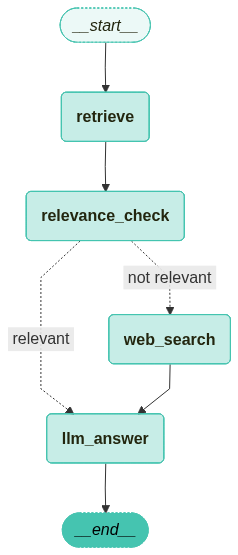

In [9]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

검색 결과의 `relevance_check` 가 실패할 경우, 검색을 수행하여 웹 검색 결과를 제공합니다.

In [10]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="2024년 노벨 문학상 수상자는?")

# 그래프 실행
invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])

==== [RELEVANCE CHECK] ====
no

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
2024년 노벨 문학상 수상자는 한국 소설가 한강(54)이다. 한강은 한국인 최초이자 아시아 여성 작가 최초로 이 상을 받았다. 스웨덴 한림원은 그녀를 “역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문”의 작가로 선정했다. 한강은 2016년 소설 『채식주의자』로 맨부커 인터내셔널상을 수상했으며, 2023년에는 『작별하지 않는다』로 프랑스 메디치 외국문학상을 받았다. 노벨상 수상자에게는 상금 1,100만 크로나(약 13억 4천만 원)와 메달, 증서가 수여된다.

**Source**  
- https://www.hani.co.kr/arti/culture/culture_general/1161999.html  
- https://www.youtube.com/watch?v=FsMuWl5LYNA  
- https://www.chosun.com/national/national_general/2024/10/10/NYUFG2FRHRFONLBT6BP6DAEUFQ/  
- https://world.kbs.co.kr/service/special_program.htm?lang=k&id=index&board_seq=758
('user', '2024년 노벨 문학상 수상자는?')
('assistant', '2024년 노벨 문학상 수상자는 한국 소설가 한강(54)이다. 한강은 한국인 최초이자 아시아 여성 작가 최초로 이 상을 받았다. 스웨덴 한림원은 그녀를 “역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문”의 작가로 선정했다. 한강은 2016년 소설 『채식주의자』로 맨부커 인터내셔널상을

In [11]:
# Callback 함수 예시
def callback_function(args):
    if args["node"] == "llm_answer":
        print(args["content"], end="", flush=True)


# 그래프 스트리밍 출력
stream_graph(
    app, inputs, config, ["relevance_check", "llm_answer"], callback=callback_function # 적용
)

==== [RELEVANCE CHECK] ====
no
2024년 노벨 문학상 수상자는 한국 소설가 한강(54)이다. 한강은 한국인 최초이자 아시아 여성 작가 최초로 이 상을 받았다. 스웨덴 한림원은 그녀를 “역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문”의 작가로 선정했다. 한강은 2016년 소설 『채식주의자』로 맨부커 인터내셔널상을 수상했으며, 2023년에는 『작별하지 않는다』로 프랑스 메디치 외국문학상을 받았다. 노벨상 상금은 1,100만 크로나(약 13억 4천만 원)이다.

**출처**  
- https://www.hani.co.kr/arti/culture/culture_general/1161999.html  
- https://www.youtube.com/watch?v=FsMuWl5LYNA  
- https://www.chosun.com/national/national_general/2024/10/10/NYUFG2FRHRFONLBT6BP6DAEUFQ/  
- https://world.kbs.co.kr/service/special_program.htm?lang=k&id=index&board_seq=758

In [12]:
# 최종 출력 확인
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 2024년 노벨 문학상 수상자는?
Answer:
2024년 노벨 문학상 수상자는 한국 소설가 한강(54)이다. 한강은 한국인 최초이자 아시아 여성 작가 최초로 이 상을 받았다. 스웨덴 한림원은 그녀를 “역사적 트라우마에 맞서고 인간 삶의 연약함을 드러내는 강렬한 시적 산문”의 작가로 선정했다. 한강은 2016년 소설 『채식주의자』로 맨부커 인터내셔널상을 수상했으며, 2023년에는 『작별하지 않는다』로 프랑스 메디치 외국문학상을 받았다. 노벨상 상금은 1,100만 크로나(약 13억 4천만 원)이다.

**출처**  
- https://www.hani.co.kr/arti/culture/culture_general/1161999.html  
- https://www.youtube.com/watch?v=FsMuWl5LYNA  
- https://www.chosun.com/national/national_general/2024/10/10/NYUFG2FRHRFONLBT6BP6DAEUFQ/  
- https://world.kbs.co.kr/service/special_program.htm?lang=k&id=index&board_seq=758
